# Taqiya Ehsan
# Programming Exercise \# 4
---

# Preamble

In [2]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive

# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
%cd /content/drive/My\ Drive/ML/ProgrammingAssignment4

Mounted at /content/drive
/content/drive/My Drive/ML/ProgrammingAssignment4


In [3]:
# import relevant Python libraries
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Machine Learning for Diagnosis of 'Senioritis'**

## Problem 1.1

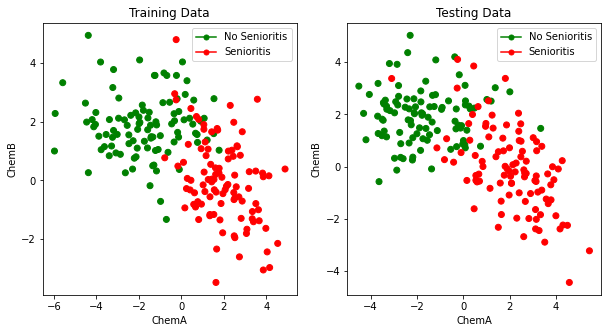

In [4]:
### Your code for 1.1 goes here ###
import matplotlib.lines as mlines
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = {'No Senioritis': 'green', 'Senioritis': 'red'}

# train data plot
train = pd.read_csv('./SenioritisTrainingData.csv')
train_label = train['ClassLabel']

ax[0].scatter(train['ChemA'], train['ChemB'], c = train_label.map(colors)) 
ax[0].set_title('Training Data')
ax[0].set_xlabel('ChemA')
ax[0].set_ylabel('ChemB')


# test data plot
test = pd.read_csv('./SenioritisTestData.csv')
test_label = test['ClassLabel']

ax[1].scatter(test['ChemA'], test['ChemB'], c = test_label.map(colors))
ax[1].set_title('Testing Data')
ax[1].set_xlabel('ChemA')
ax[1].set_ylabel('ChemB')

green_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='No Senioritis')
red_dot = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Senioritis')
ax[0].legend(handles=[green_dot, red_dot])
ax[1].legend(handles=[green_dot, red_dot])

plt.show();

## Problem 1.2

In [5]:
# helper functions
def euclidean_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

### (a)

In [82]:
### Your code for 1.2(a) goes here ###
class LDA():
  def __init__(self):
    self.estimates = None

  def fit(self, X, y):
    classes = list(np.unique(y))
    variance = np.cov(X[:, 1:3].T.astype(float))

    # list of tuples that contain estimates for each class is in the form (class, prior, mean, variance)
    estimates = []

    for l in classes:
      # have it as a list originally, then turn it into a tuple
      class_estimate = []

      # add the class as the first element of the tuple
      class_estimate.append(l)

      # first we want to subset the data for that particular class
      # get the indices of the rows for this particular class
      indices_of_rows = np.where(X[:, 0] == l) 
      X_l = X[indices_of_rows][:, 1:3]

      prior = len(X_l)/len(X)
      class_estimate.append(prior)

      # reshape makes it a proper column vector
      mean = (np.sum(X_l, axis=0) / len(X_l)).reshape(-1,1)
      class_estimate.append(mean)
      
      class_estimate.append(variance)
      
      estimates.append(tuple(class_estimate))

    self.estimates = estimates
    return estimates
  
  def predict(self, x, senioritis, no_senioritis):
    # x is a sample => (1, 2)

    variance = senioritis[3]

    prior_senioritis = senioritis[1]
    mean_senioritis = senioritis[2]
    prior_no_senioritis = no_senioritis[1]
    mean_no_senioritis = no_senioritis[2]
    
    score_senioritis = np.log(prior_senioritis) - (1/2 * ((mean_senioritis.T) @ np.linalg.inv(variance)) @ (mean_senioritis)) + (x @ np.linalg.inv(variance) @ mean_senioritis)
    score_senioritis = score_senioritis.flatten()[0] 

    score_no_senioritis = np.log(prior_no_senioritis) - (1/2 * ((mean_no_senioritis.T) @ np.linalg.inv(variance)) @ (mean_no_senioritis)) + (x @ np.linalg.inv(variance) @ mean_no_senioritis)
    score_no_senioritis = score_no_senioritis.flatten()[0] 

    if (score_no_senioritis >= score_senioritis): return 'No Senioritis'
    
    return 'Senioritis' 

  def decision_boundary(self, x, senioritis, no_senioritis):
    variance = senioritis[3]
    prior_senioritis = senioritis[1]
    mean_senioritis = senioritis[2]

    prior_no_senioritis = no_senioritis[1]
    mean_no_senioritis = no_senioritis[2]
    
    score_senioritis = np.log(prior_senioritis) - (1/2 * ((mean_senioritis.T) @ np.linalg.inv(variance)) @ (mean_senioritis)) + (x @ np.linalg.inv(variance) @ mean_senioritis)
    score_senioritis = score_senioritis.flatten()[0] 

    score_no_senioritis = np.log(prior_no_senioritis) - (1/2 * ((mean_no_senioritis.T) @ np.linalg.inv(variance)) @ (mean_no_senioritis)) + (x @ np.linalg.inv(variance) @ mean_no_senioritis)
    score_no_senioritis = score_no_senioritis.flatten()[0] 

    return np.argmax([score_senioritis, score_no_senioritis])

In [83]:
X_lda = np.array(train)
y_lda = np.array(train['ClassLabel'])

lda = LDA()
estimates = lda.fit(X_lda, y_lda)

no_senioritis = estimates[0]
senioritis = estimates[1]

predictions_lda = []

for idx in range(len(X_lda)):
  x = X_lda[:, 1:3][idx]
  predictions_lda.append(lda.predict(x, senioritis, no_senioritis))

print(f"LDA classification training accuracy = {accuracy(y_lda, predictions_lda)*100}")

LDA classification training accuracy = 91.0


### (b)

In [85]:
### Your code for 1.2(b) goes here ###
class QDA():
  def __init__(self):
    self.estimates = None

  def fit(self, X, y):
    classes = list(np.unique(y))

    # list of tuples that contain estimates for each class is in the form (class, prior, mean, variance)
    estimates = []

    for l in classes:
      # have it as a list originally, then turn it into a tuple
      class_estimate = []

      # add the class as the first element of the tuple
      class_estimate.append(l)

      # first we want to subset the data for that particular class
      # get the indices of the rows for this particular class
      indices_of_rows = np.where(X[:, 0] == l) 
      X_l = X[indices_of_rows][:, 1:3]

      prior = len(X_l)/len(X)
      class_estimate.append(prior)

      # reshape makes it a proper column vector
      mean = (np.sum(X_l, axis=0) / len(X_l)).reshape(-1,1).astype(float)
      class_estimate.append(mean)
      
      variance = np.cov(X_l.T.astype(float))
      class_estimate.append(variance)
      
      estimates.append(tuple(class_estimate))

    self.estimates = estimates
    return estimates
  
  def predict(self, x, senioritis, no_senioritis):

    prior_senioritis = senioritis[1]
    mean_senioritis = senioritis[2]
    variance_senioritis = senioritis[3]

    prior_no_senioritis = no_senioritis[1]
    mean_no_senioritis = no_senioritis[2]
    variance_no_senioritis = no_senioritis[3]
    
    score_senioritis = np.log(prior_senioritis) - (1/2 * np.log(np.linalg.det(variance_senioritis))) - (1/2 * (mean_senioritis).T @ (variance_senioritis) @ (mean_senioritis)) + (x.T @ (np.linalg.inv(variance_senioritis)) @ mean_senioritis) - (1/2 * x.T @ np.linalg.inv(variance_senioritis) @ x)
    score_senioritis = score_senioritis.flatten()[0] 

    score_no_senioritis = np.log(prior_no_senioritis) - (1/2 * np.log(np.linalg.det(variance_no_senioritis))) - (1/2 * (mean_no_senioritis).T @ (variance_no_senioritis) @ (mean_no_senioritis)) + (x.T @ (np.linalg.inv(variance_no_senioritis)) @ mean_no_senioritis) - (1/2 * x.T @ np.linalg.inv(variance_no_senioritis) @ x)
    score_no_senioritis = score_no_senioritis.flatten()[0] 

    if (score_no_senioritis >= score_senioritis): return 'No Senioritis'
    
    return 'Senioritis'

  def decision_boundary(self, x, senioritis, no_senioritis):
    prior_senioritis = senioritis[1]
    mean_senioritis = senioritis[2]
    variance_senioritis = senioritis[3]

    prior_no_senioritis = no_senioritis[1]
    mean_no_senioritis = no_senioritis[2]
    variance_no_senioritis = no_senioritis[3]
    
    score_senioritis = np.log(prior_senioritis) - (1/2)*(np.log(np.linalg.det(variance_senioritis))) - (1/2)*((mean_senioritis).T @ (variance_senioritis) @ (mean_senioritis)) + (x.T @ (np.linalg.inv(variance_senioritis)) @ mean_senioritis) - (1/2)*(x.T @ np.linalg.inv(variance_senioritis) @ x)
    score_senioritis = score_senioritis.flatten()[0] 

    score_no_senioritis = np.log(prior_no_senioritis) - (1/2)*(np.log(np.linalg.det(variance_no_senioritis))) - (1/2)*((mean_no_senioritis).T @ (variance_no_senioritis) @ (mean_no_senioritis)) + (x.T @ (np.linalg.inv(variance_no_senioritis)) @ mean_no_senioritis) - (1/2)*(x.T @ np.linalg.inv(variance_no_senioritis) @ x)
    score_no_senioritis = score_no_senioritis.flatten()[0] 

    return np.argmax([score_senioritis, score_no_senioritis])

In [86]:
X_qda = np.array(train)
y_qda = np.array(train['ClassLabel'])

qda = QDA()
estimates = qda.fit(X_qda, y_qda)

no_senioritis = estimates[0]
senioritis = estimates[1]

predictions_qda = []

for idx in range(len(X_qda)):
  x = X_qda[:, 1:3][idx] 
  predictions_qda.append(qda.predict(x, senioritis, no_senioritis))

print(f"QDA classification training accuracy = {accuracy(y_qda, predictions_qda)*100}")

QDA classification training accuracy = 80.5


### (c)

In [88]:
### Your code for 1.2(c) goes here ### 
class GNB:
  def fit(self, X, y):
    n_samples, n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)

    # calculate mean, var, and prior for each class
    self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
    self._var = np.zeros((n_classes, n_features), dtype=np.float64)
    self._priors = np.zeros(n_classes, dtype=np.float64)

    for idx, l in enumerate(self._classes):
      X_l = X[y == l]
      self._mean[idx, :] = X_l.mean(axis=0)
      self._var[idx, :] = X_l.var(axis=0)
      self._priors[idx] = X_l.shape[0] / float(n_samples)
      
  def predict(self, X):
    y_pred = [self._predict(x) for x in X]
    return np.array(y_pred)

  def _predict(self, x):
    posteriors = []
      
    # calculate posterior probability for each class
    for idx, l in enumerate(self._classes):
        prior = np.log(self._priors[idx])
        posterior = np.sum(np.log(self._pdf(idx, x)))
        posterior = prior + posterior
        posteriors.append(posterior)
          
    # return class with highest posterior probability
    return self._classes[np.argmax(posteriors)]

  def _pdf(self, class_idx, x):
    mean = self._mean[class_idx]
    var = self._var[class_idx]
    numerator = np.exp(-((x - mean) ** 2) / (2 * var))
    denominator = np.sqrt(2 * np.pi * var)
    return numerator / denominator

  def __predict_proba(self, x):
    posteriors = []
      
    # calculate posterior probability for each class
    for idx, l in enumerate(self._classes):
        prior = np.log(self._priors[idx])
        posterior = np.sum(np.log(self._pdf(idx, x)))
        posterior = prior + posterior
        posteriors.append(posterior)
          
    # return class with highest posterior probability
    return np.argmax(posteriors)

  def predict_proba(self, X):
    y_pred = [self.__predict_proba(x) for x in X]
    return np.array(y_pred)

In [89]:
X_gnb = np.array(train.iloc[:, 1:3])
y_gnb = np.array(train['ClassLabel'])
gnb = GNB()
gnb.fit(X_gnb, y_gnb)
gnb_predictions = gnb.predict(X_gnb)
acc_gnb = accuracy(gnb_predictions, y_gnb)
print("GNB classification training accuracy", acc_gnb*100)

GNB classification training accuracy 90.5


### (d)

In [91]:
### Your code for 1.2(d) goes here ###
from collections import Counter
class kNN:
  def __init__(self, k=3):
    self.k = k
    
  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    y_pred = [self._predict(x) for x in X]
    return np.array(y_pred)

  def _predict(self, x):
    # Compute distances between x and all examples in the training set
    distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
    # Sort by distance and return indices of the first k neighbors
    k_idx = np.argsort(distances)[: self.k]
    # Extract the labels of the k nearest neighbor training samples
    k_neighbor_labels = [self.y_train[i] for i in k_idx]
    # return the most common class label
    most_common = Counter(k_neighbor_labels).most_common(1)
    return most_common[0][0]
  
  def decision_boundary(self, X):
    y_pred = [self._predict(x) for x in X]
    y_pred = np.array(y_pred)
    y_pred[y_pred == 'Senioritis'] = 1
    y_pred[y_pred == 'No Senioritis'] = 0

    return y_pred.astype(np.int64)

In [92]:
X_knn = np.array(train.iloc[:, 1:3])
y_knn = np.array(train['ClassLabel'])
knn = kNN(k=3)
knn.fit(X_knn, y_knn)
knn_predictions = knn.predict(X_knn)
acc_knn = accuracy(knn_predictions, y_knn)
print("KNN classification training accuracy", acc_knn*100)

KNN classification training accuracy 95.0


## Problem 1.3

In [14]:
# prep test data
X_test = np.array(test)
y_test = np.array(test['ClassLabel'])

lda_preds = []
qda_preds = []
for idx in range(len(X_test)):
  x = X_test[:, 1:3][idx]
  lda_preds.append(lda.predict(x, senioritis, no_senioritis))
  qda_preds.append(qda.predict(x, senioritis, no_senioritis))

gnb_preds = gnb.predict(np.array(test.iloc[:, 1:3])) 
knn_preds = knn.predict(np.array(test.iloc[:, 1:3]))

p = (y_test == 'Senioritis').sum()
n = (y_test == 'No Senioritis').sum()

assert(len(lda_preds) == len(qda_preds) == len(knn_preds) == len(gnb_preds))

### (a)

In [15]:
### Your code for 1.3(a) goes here ###
def error(y_true, y_pred):
  err = np.sum(y_true != y_pred) / len(y_true)
  return (err)

err_lda = error(y_test, lda_preds)
err_qda = error(y_test, qda_preds) 
err_gnb = error(y_test, gnb_preds)
err_knn = error(y_test, knn_preds) 

print(f'Probability of Error/Misclassification:\nLDA = {err_lda}\nQDA = {err_qda}\nNaive Bayes = {err_gnb}\nkNN = {err_knn}')

Probability of Error/Misclassification:
LDA = 0.09
QDA = 0.165
Naive Bayes = 0.085
kNN = 0.095


### (b)

In [16]:
### Your code for 1.3(b) goes here ###
# True Positive
tp_lda, tp_qda, tp_gnb, tp_knn = 0, 0, 0, 0

for c in range(len(lda_preds)):
  if(lda_preds[c] == 'Senioritis' and y_test[c] == 'Senioritis'): tp_lda = tp_lda + 1
  if(qda_preds[c] == 'Senioritis' and y_test[c] == 'Senioritis'): tp_qda = tp_qda + 1
  if(gnb_preds[c] == 'Senioritis' and y_test[c] == 'Senioritis'): tp_gnb = tp_gnb + 1
  if(knn_preds[c] == 'Senioritis' and y_test[c] == 'Senioritis'): tp_knn = tp_knn + 1  

print(f'True Positives:\nLDA = {tp_lda}\nQDA = {tp_qda}\nNaive Bayes = {tp_gnb}\nkNN = {tp_knn}')
print(" ")
print(f'True Positive Rates:\nLDA = {tp_lda/p}\nQDA = {tp_qda/p}\nNaive Bayes = {tp_gnb/p}\nkNN = {tp_knn/p}')

True Positives:
LDA = 92
QDA = 99
Naive Bayes = 86
kNN = 91
 
True Positive Rates:
LDA = 0.92
QDA = 0.99
Naive Bayes = 0.86
kNN = 0.91


### (c)

In [17]:
### Your code for 1.3(c) goes here ###
# False Positive
fp_lda, fp_qda, fp_gnb, fp_knn = 0, 0, 0, 0

for c in range(len(lda_preds)):
  if(lda_preds[c] == 'Senioritis' and y_test[c] == 'No Senioritis'): fp_lda = fp_lda + 1
  if(qda_preds[c] == 'Senioritis' and y_test[c] == 'No Senioritis'): fp_qda = fp_qda + 1
  if(gnb_preds[c] == 'Senioritis' and y_test[c] == 'No Senioritis'): fp_gnb = fp_gnb + 1
  if(knn_preds[c] == 'Senioritis' and y_test[c] == 'No Senioritis'): fp_knn = fp_knn + 1  

print(f'False Positives:\nLDA = {fp_lda}\nQDA = {fp_qda}\nNaive Bayes = {fp_gnb}\nkNN = {fp_knn}')
print(" ")
print(f'False Positive Rates:\nLDA = {fp_lda/n}\nQDA = {fp_qda/n}\nNaive Bayes = {fp_gnb/n}\nkNN = {fp_knn/n}')

False Positives:
LDA = 10
QDA = 32
Naive Bayes = 3
kNN = 10
 
False Positive Rates:
LDA = 0.1
QDA = 0.32
Naive Bayes = 0.03
kNN = 0.1


### (d)

In [18]:
### Your code for 1.3(d) goes here ###
# True Negative
tn_lda, tn_qda, tn_gnb, tn_knn = 0, 0, 0, 0

for c in range(len(lda_preds)):
  if(lda_preds[c] == 'No Senioritis' and y_test[c] == 'No Senioritis'): tn_lda = tn_lda + 1
  if(qda_preds[c] == 'No Senioritis' and y_test[c] == 'No Senioritis'): tn_qda = tn_qda + 1
  if(gnb_preds[c] == 'No Senioritis' and y_test[c] == 'No Senioritis'): tn_gnb = tn_gnb + 1
  if(knn_preds[c] == 'No Senioritis' and y_test[c] == 'No Senioritis'): tn_knn = tn_knn + 1  

print(f'True Negatives:\nLDA = {tn_lda}\nQDA = {tn_qda}\nNaive Bayes = {tn_gnb}\nkNN = {tn_knn}')
print(" ")
print(f'True Negative Rate:\nLDA = {tn_lda/n}\nQDA = {tn_qda/n}\nNaive Bayes = {tn_gnb/n}\nkNN = {tn_knn/n}')

True Negatives:
LDA = 90
QDA = 68
Naive Bayes = 97
kNN = 90
 
True Negative Rate:
LDA = 0.9
QDA = 0.68
Naive Bayes = 0.97
kNN = 0.9


### (e)

In [19]:
### Your code for 1.3(e) goes here ###
# False Negative
fn_lda, fn_qda, fn_gnb, fn_knn = 0, 0, 0, 0

for c in range(len(lda_preds)):
  if(lda_preds[c] == 'No Senioritis' and y_test[c] == 'Senioritis'): fn_lda = fn_lda + 1
  if(qda_preds[c] == 'No Senioritis' and y_test[c] == 'Senioritis'): fn_qda = fn_qda + 1
  if(gnb_preds[c] == 'No Senioritis' and y_test[c] == 'Senioritis'): fn_gnb = fn_gnb + 1
  if(knn_preds[c] == 'No Senioritis' and y_test[c] == 'Senioritis'): fn_knn = fn_knn + 1  

print(f'False Negatives:\nLDA = {fn_lda}\nQDA = {fn_qda}\nNaive Bayes = {fn_gnb}\nkNN = {fn_knn}')
print(" ")
print(f'False Negative Rate:\nLDA = {fn_lda/p}\nQDA = {fn_qda/p}\nNaive Bayes = {fn_gnb/p}\nkNN = {fn_knn/p}')

False Negatives:
LDA = 8
QDA = 1
Naive Bayes = 14
kNN = 9
 
False Negative Rate:
LDA = 0.08
QDA = 0.01
Naive Bayes = 0.14
kNN = 0.09


## Problem 1.4

_[Your answer for 1.4 goes here]_

Based on the evaluation metrics above, I would recommend the Naive Bayes (GNB) classifier for automated diagnostics of Senioritis. The GNB classifier has a low probability of error as well as the high True Positive count and low False Negative count. Although it does not have the best statistics for True Negative or False Positive, the counts are still relatively decent.

## Problem 1.5

### (a)

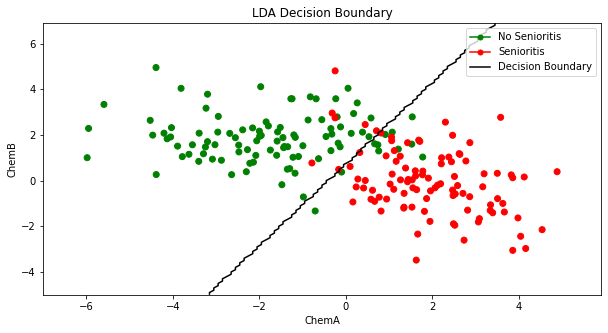

In [84]:
### Your code for 1.5(a) goes here ###
fig, ax = plt.subplots(figsize=(10, 5))
colors = {'No Senioritis': 'green', 'Senioritis': 'red'}
x_l = np.linspace(-4, 6)

# train data plot
ax.scatter(train['ChemA'], train['ChemB'], c = train_label.map(colors))
ax.set_title('LDA Decision Boundary')
ax.set_xlabel('ChemA')
ax.set_ylabel('ChemB')

green_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='No Senioritis')
red_dot = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Senioritis')
blue_line = mlines.Line2D([], [], color='k', markersize=5, label='Decision Boundary')
ax.legend(handles=[green_dot, red_dot, blue_line])

x_min = -7
x_max = 6
y_min = -5
y_max = 7

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = []

for i in range(xx.shape[0]):
  for j in range(xx.shape[1]):
    z = np.array([xx[i][j], yy[i][j]]) 
    Z.append(lda.decision_boundary(z, senioritis, no_senioritis))

Z = np.array(Z).reshape(xx.shape) 

ax.contour(xx, yy, Z, [0.5], colors='k') 

plt.show(); 

### (b)

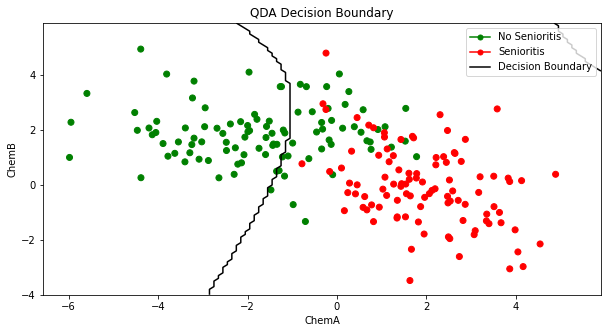

In [87]:
### Your code for 1.5(b) goes here ###
fig, ax = plt.subplots(figsize=(10, 5))
colors = {'No Senioritis': 'green', 'Senioritis': 'red'}

# train data plot
ax.scatter(train['ChemA'], train['ChemB'], c = train_label.map(colors))
ax.set_title('QDA Decision Boundary')
ax.set_xlabel('ChemA')
ax.set_ylabel('ChemB')
green_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='No Senioritis')
red_dot = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Senioritis')
blue_line = mlines.Line2D([], [], color='black', markersize=5, label='Decision Boundary')
ax.legend(handles=[green_dot, red_dot, blue_line])

# plot decision boundary
xx, yy = np.meshgrid(np.arange(-4, 6, 0.1), np.arange(-4, 6, 0.1)) 
Z = []

for i in range(xx.shape[0]):
  for j in range(xx.shape[1]):
    z = np.array([xx[i][j], yy[i][j]]) 
    Z.append(qda.decision_boundary(z, senioritis, no_senioritis))

Z = np.array(Z).reshape(xx.shape) 

ax.contour(xx, yy, Z, [0.5], colors='k') 
plt.show(); 

### (c)

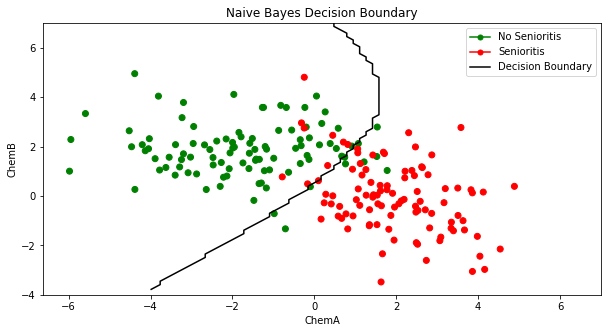

In [90]:
### Your code for 1.5(c) goes here ###
fig, ax = plt.subplots(figsize=(10, 5))
colors = {'No Senioritis': 'green', 'Senioritis': 'red'}

# train data plot
ax.scatter(train['ChemA'], train['ChemB'], c = train_label.map(colors))
ax.set_title('Naive Bayes Decision Boundary')
ax.set_xlabel('ChemA')
ax.set_ylabel('ChemB')

# plot decision boundary
xlim = (-4, 7)
ylim = (-4, 7)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))

Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contour(xx, yy, Z, [0.5], colors='k')

green_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='No Senioritis')
red_dot = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Senioritis')
blue_line = mlines.Line2D([], [], color='black', markersize=5, label='Decision Boundary')
ax.legend(handles=[green_dot, red_dot, blue_line])

plt.show(); 

### (d)

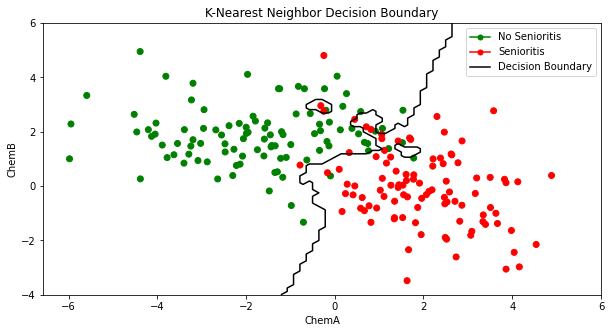

In [93]:
### Your code for 1.5(d) goes here ###
fig, ax = plt.subplots(figsize=(10, 5))
colors = {'No Senioritis': 'green', 'Senioritis': 'red'}

# train data plot
ax.scatter(train['ChemA'], train['ChemB'], c = train_label.map(colors))
ax.set_title('K-Nearest Neighbor Decision Boundary')
ax.set_xlabel('ChemA')
ax.set_ylabel('ChemB')

green_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='No Senioritis')
red_dot = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Senioritis')
blue_line = mlines.Line2D([], [], color='black', markersize=5, label='Decision Boundary')
ax.legend(handles=[green_dot, red_dot, blue_line])

# plot decision boundary
xlim = (-4, 6)
ylim = (-4, 6)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))

Z = knn.decision_boundary(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contour(xx, yy, Z, [0.5], colors='k')

plt.show(); 

### (e)

In [94]:
### Your code for 1.5(e) goes here ###
import math
def Bayes(x):

  mean_0 = np.array([-2,2])
  mean_1 = np.array([2,0])

  cov_0 = np.array([[3,0],[0,1]])
  cov_1 = np.array([[2,-1],[-1,2]])
  
  den_0 = math.pow(2*math.pi, 50) * np.sqrt(np.linalg.det(cov_0))
  temp_0 = np.subtract(x, mean_0)
  temp_1 = np.matmul(temp_0,np.linalg.inv(cov_0))
  exp_0 = 0.5 * np.matmul(temp_1, temp_0.transpose())
  S0 = 1/den_0 * np.exp(exp_0)
  S0 = S0[0][0]

  den_1 = math.pow(2*math.pi, 50) * np.sqrt(np.linalg.det(cov_1))
  temp_2 = np.subtract(x, mean_1)
  temp_3 = np.matmul(temp_2, np.linalg.inv(cov_1))
  exp_1 = 0.5 * np.matmul(temp_3, temp_2.transpose())
  S1 = 1/den_1 * np.exp(exp_1)
  S1 = S1[0][0]

  if S0 < S1: return 0
  else: return 1

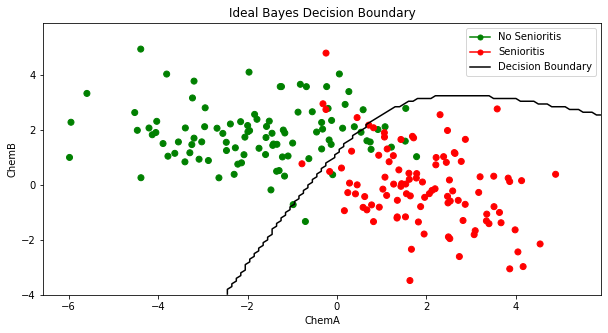

In [95]:
xx, yy = np.meshgrid(np.arange(-4, 6, 0.1), np.arange(-4, 6, 0.1))

Z = np.zeros(xx.shape)
for i in range(xx.shape[0]):
  for j in range(xx.shape[1]):
    Z[i][j] = Bayes([[xx[i][j],yy[i][j]]])

fig, ax = plt.subplots(figsize=(10, 5))
colors = {'No Senioritis': 'green', 'Senioritis': 'red'}

# train data plot
ax.scatter(train['ChemA'], train['ChemB'], c = train_label.map(colors))
ax.set_title('Ideal Bayes Decision Boundary')
ax.set_xlabel('ChemA')
ax.set_ylabel('ChemB')

green_dot = mlines.Line2D([], [], color='green', marker='o', markersize=5, label='No Senioritis')
red_dot = mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Senioritis')
blue_line = mlines.Line2D([], [], color='black', markersize=5, label='Decision Boundary')
ax.legend(handles=[green_dot, red_dot, blue_line])

plt.contour(xx, yy, Z, [0.5], colors='k')
plt.show(); 

## Problem 1.6


### (a)

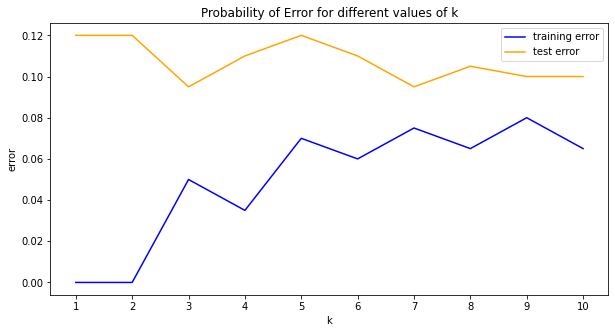

In [96]:
### Your code for 1.6(a) goes here ###
k_interval = np.arange(1, 11)

X_train_knn = np.array(train.iloc[:, 1:3])
y_train_knn = np.array(train['ClassLabel'])
X_test_knn = np.array(test.iloc[:, 1:3])
y_test_knn = np.array(test['ClassLabel'])

train_error = []
test_error = []

for k in k_interval:
  # print(k)
  knn_ = kNN(k=k)
  knn_.fit(X_train_knn, y_train_knn)

  train_preds = knn_predictions = knn_.predict(X_train_knn)
  test_preds = knn_predictions = knn_.predict(X_test_knn)

  train_error.append(1 - np.sum(y_train_knn == train_preds) / len(y_train_knn))
  test_error.append(1 - np.sum(y_test_knn == test_preds) / len(y_test_knn))

  # print(f'{k} done')

# print(f'Train Errors = {train_error}')
# print(f'Test Errors = {test_error}')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(k_interval, train_error, color='blue')
ax.plot(k_interval, test_error, color='orange')

plt.xticks(np.arange(1, 11, step=1))
ax.set_xlabel('k')
ax.set_ylabel('error')
ax.set_title('Probability of Error for different values of k')
ax.legend(["training error", "test error"], loc ="upper right")
plt.show();

### (b)

_[Your answer for 1.6(b) goes here]_

Inspecting the training vs test error plot carefully, we can see that the training error progressively increases while testing error decreases with increasing values of k from 1 to 10. Around the region (7, 10) both errors plateau, but at k = 7 as it would be the best balance between reasonable computational cost and error.

So, I would recommend k = 7 for the kNN classifier should it go into production for diagnostics of Senioritis.